# OTUS Ablation Study Paper Plots | $p p > Z > e^+ e^-$

This notebook creates the plots which are found in the paper: https://arxiv.org/abs/2101.08944. 

# Load Required Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.cm as cm
from scipy import stats

# Add utilityFunctions/ to easily use utility .py files
import sys
sys.path.append("../../utilityFunctions")

# Meta Parameters

In [2]:
#-- Set appropriate lambda value --#
# allLambs    = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
selectLambs = [0.001, 1, 100]
lamb = selectLambs[2]
print('lamb = ', lamb)

lamb =  100


In [3]:
save_figs = True  # Global switch to turn on saving figures to files
N_slices  = 1000  # Global number of slices to calculate SW distance with

data_directory    = '../../data/'
dataset_name      = 'ppzee'
results_dataPath  = '../../experiments/'+dataset_name+f'/ablationStudy/lambda_tuning/npzFiles/swae-lamb={lamb}.npz'
img_dir           = dataset_name+'_lambTuningImages/'

np.random.seed(4) # Set numpy random seed

# Get Truth Datasets and Model Results

The data was split into training, validation, and two testing sets. We load only the validation datasets here and split them in two. We also load in the model results calculated on one of the testing datasets.  

Note that we have two separate validation sets to ensure the independence of samples when performing statistical tests.

Specifically, we have 4 initial datasets: x_val1, z_val1, x_val2, and z_val2.

Validation set 1 has been used to obtain network results. These results will be compared to the independent validation set 2.

For testing the encoder's performance we will use the following convention:
- z_pred_val1 = E(x_val1, $\epsilon$)

In plots this will be denoted as $x \rightarrow \tilde{z}$.

For testing the decoder's performance we will use the following convention:
- x_pred_truth_val1 = D(z_val1, $\epsilon$)

In plots this will be denoted as $z \rightarrow \tilde{x}'$.

For testing the overall performance of the full encoder-decoder chain we will use the following convention:
- x_pred_val1 = D(E(x_val1, $\epsilon$), $\epsilon$)

In plots this will be denoted as $x \rightarrow \tilde{z} \rightarrow \tilde{x}$.

Note that $\epsilon$ denotes the random noise input of the networks. Note that all $\epsilon$ are different random samples. This happens internally and thus won't be shown in what follows.

## Load in Validation Data and Results

In [4]:
valData = np.load(results_dataPath)

#-- Load truth data --#
zData = valData['z']
xData = valData['x']

#-- Load results data --#
zPred      = valData['x_encoded']        # E(x)
xPred      = valData['x_reconstructed']  # D(E(x))
xPredTruth = valData['z_decoded']        # D(z)

#-- Split data into the two separate validation sets --#
f = int(0.5*zData.shape[0])

x_val1  = xData[0:f]
z_val1  = zData[0:f]

x_val2  = xData[f:]
z_val2  = zData[f:]

#-- Make sure validation sets have the same number of events --#
assert(x_val1.shape[0] == x_val2.shape[0])
assert(z_val1.shape[0] == z_val2.shape[0])
print('z_val1 Shape, x_val1 Shape: ', z_val1.shape, x_val1.shape)
print('z_val2 Shape, x_val2 Shape: ', z_val2.shape, x_val2.shape)

#-- Get predicted z for x_val1, E(x_val1) --#
z_pred_val1 = zPred[0:f]

#-- Get predicted x for full autoencoder chain, D(E(x_val1)) --#
x_pred_val1 = xPred[0:f]

#-- Get predicted x for true z_val1, D(z_val1) --#
x_pred_truth_val1 = xPredTruth[0:f]   

z_val1 Shape, x_val1 Shape:  (20000, 8) (20000, 8)
z_val2 Shape, x_val2 Shape:  (20000, 8) (20000, 8)


# Define Statistical Tests That We Will Use

For each one-dimensional distribution we will perform the following statistical tests:

- $\chi^2$
- 2-sample, 2-sided Kolmogorov-Smirov test

We will also report the 1D Wasserstein distance.

z-space plots will compare
- z_val2 with z_pred_val1 

In plots this will be denoted as $z$ vs $\tilde{z}$. 

x-space plots will compare
- x_val2 with x_pred_val1 

In plots this will be denoted as $x$ vs $\tilde{x}$. 
- x_val2 with x_pred_truth_val1 

In plots this will be denoted as $x$ vs $\tilde{x}'$.


## Import statistical test functions

In [5]:
from func_utils import runStatAnalysis
from func_utils import sliced_wd_numpy as avSWDistance
# ReducedChiSq(), W1Dist() #?, KSTest(), runStatAnalysis(), generateTheta() #?, avSWDistance() #?

## Calculate SW Distance Results (Global Metric) Over N_Slices

### z-space results

In [6]:
print(r"SW distance $z$ vs $\tilde{z}$: ", avSWDistance(z_val2, z_pred_val1, N_slices))

SW distance $z$ vs $\tilde{z}$:  1.9276431974871424


### x-space results

In [7]:
print(r"SW distance $x$ vs $\tilde{x}$: ", avSWDistance(x_val2, x_pred_val1, N_slices))
print(r"SW distance $x$ vs $\tilde{x}^\prime$: ", avSWDistance(x_val2, x_pred_truth_val1, N_slices))

SW distance $x$ vs $\tilde{x}$:  3.490635614148151
SW distance $x$ vs $\tilde{x}^\prime$:  31.121357671907372


## Run Statistical Analysis for Principal Axes

We run the statistical analysis on the principal axis plots that are shown in the paper. These plots are for the positron's ($e^+$) $p_Y$, $p_Z$, and $E$ in both z-space and x-space.  

We first find the correct binning such that no bin has less than 5 entries (necessary for $\chi^2$ test). We store this binning in a list to use in later plotting.

### z-space Find Correct Binning

In [8]:
# Want to find binsY such that n has no bins with <5 entries
binsY = [-100, -60] + [-50+5*i for i in range(20+1)] + [60, 100]
n, _, _ = plt.hist(z_pred_val1[:,5], bins=binsY, histtype='step', density=False)
print("Number of entries in each bin: ",n)
print("Do any bins have less than 5 entries? ",np.any(n < 5))

plt.close() # Don't show plot

Number of entries in each bin:  [  13.   49.  385.  885. 1198. 1172. 1149. 1183. 1031.  989.  880.  888.
  927.  877.  962. 1064. 1170. 1248. 1231. 1183. 1013.  427.   58.   14.]
Do any bins have less than 5 entries?  False


### x-space Find Correct Binning

In [9]:
# Check if above z-space bins will work for x-space too
n, _, _ = plt.hist(x_pred_val1[:,5], bins=binsY, histtype='step', density=False)
print("Number of entries in each bin: ",n)
print("Do any bins have less than 5 entries? ",np.any(n < 5))

plt.close() # Don't show plot

Number of entries in each bin:  [   6.   41.  218.  761. 1163. 1295. 1240. 1147. 1121. 1016.  943.  895.
  872.  924.  995. 1052. 1117. 1266. 1295. 1214.  985.  329.   85.   15.]
Do any bins have less than 5 entries?  False


### Run statistical analysis for z-space principal axis data

In [10]:
#-- Define suitable binning for principal axis data (obtained from above) --#
bins_py = binsY       

zbinsList = [bins_py]

In [11]:
#-- z-space principal axis data --#
zStatsList = []

for j in range(len(zbinsList)):
    
    k = (j+1) + 4
              
    zStatsList.append(runStatAnalysis(z_pred_val1[:,k], z_val2[:,k], zbinsList[j]))


In [12]:
#-- Demonstration of how to access statistical test information --#
print(len(zStatsList))
print('W1D, KSstat, KSpval, RC2, dof, chi2pval')
print(zStatsList[0])
print("")
print('W1D: %.2E'% zStatsList[0][0])
print('(KSstat, pval): (%.2E, %.3f)' % (zStatsList[0][1], zStatsList[0][2]))
print('(RC2, dof, pval): (%.3f, %d, %.3f)' % (zStatsList[0][3], zStatsList[0][4], zStatsList[0][5]))

1
W1D, KSstat, KSpval, RC2, dof, chi2pval
(0.61681616, 0.012950000000000017, 0.06988211803559509, 10.579424077044393, 23, 0.0)

W1D: 6.17E-01
(KSstat, pval): (1.30E-02, 0.070)
(RC2, dof, pval): (10.579, 23, 0.000)


### Run statistical analysis for x-space principal axis  data

In [13]:
xbinsList = zbinsList 

In [14]:
#-- x-space principal axis data --#
xStatsList = []
xStatsListTruth = []

for j in range(len(xbinsList)):
    
    k = (j+1) + 4
              
    xStatsList.append(runStatAnalysis(x_pred_val1[:,k], x_val2[:,k], xbinsList[j]))
        
    xStatsListTruth.append(runStatAnalysis(x_pred_truth_val1[:,k], x_val2[:,k], xbinsList[j]))


In [15]:
#-- Demonstration of how to access statistical test information --#
print(len(xStatsList))
print('W1D, KSstat, KSpval, RC2, dof, chi2pval')
print(xStatsList[0])
print("")
print('W1D: %.2E'% xStatsList[0][0])
print('(KSstat, pval): (%.2E, %.3f)' % (xStatsList[0][1], xStatsList[0][2]))
print('(RC2, dof, pval): (%.3f, %d, %.3f)' % (xStatsList[0][3], xStatsList[0][4], xStatsList[0][5]))

1
W1D, KSstat, KSpval, RC2, dof, chi2pval
(1.8222783, 0.02635, 1.8630366025431484e-06, 9.072480685219235, 23, 0.0)

W1D: 1.82E+00
(KSstat, pval): (2.63E-02, 0.000)
(RC2, dof, pval): (9.072, 23, 0.000)


# Make Principal Axes Plots

## Load Plotting Functions

In [16]:
from plot_utils import ratioPlotSingle, ratioPlotDouble, transportPlot

## Create Principal Axes Plots z-space

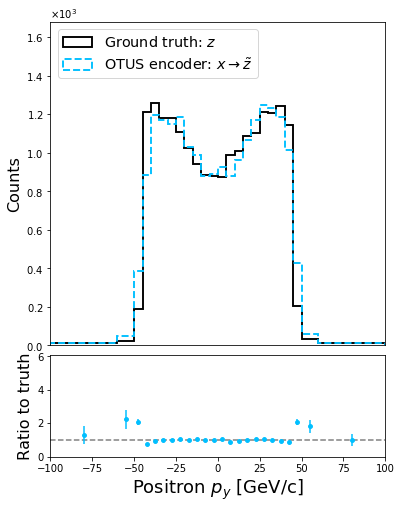

In [17]:
#-- Plot this for the positron's py --#
ratioPlotSingle(z_val2[:,5], z_pred_val1[:,5], zbinsList[0], (-100,100), (0,7000), (0., 6.05), 
                   r'Positron $p_y$ [GeV/c]', legend=True, save_figs=save_figs, img_dir=img_dir, ablLambda=f'lamb={lamb}') #zStatsList[0],

## Create Principal Axes Plots x-space

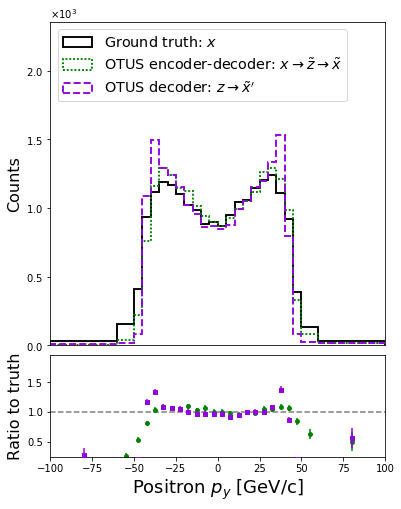

In [18]:
#-- Plot this for the positron's py --#
ratioPlotDouble(x_val2[:,5], x_pred_val1[:,5], x_pred_truth_val1[:,5], xbinsList[0], 
                   (-100,100), (0,7000), (.25,1.95), 
                   r'Positron $p_y$ [GeV/c]', legend=True, save_figs=save_figs, img_dir=img_dir, ablLambda=f'lamb={lamb}')

# Calculate Invariant Mass of Z Boson

In [19]:
from func_utils import calcInvM

In [20]:
#-- Calculate Invariant Mass of Z boson --#

# x-space
xpred_IM_Z      = calcInvM(x_pred_val1[:,0:4] + x_pred_val1[:,4:8])
xval_IM_Z       = calcInvM(x_val2[:,0:4] + x_val2[:,4:8])
xpredtruth_IM_Z = calcInvM(x_pred_truth_val1[:,0:4] + x_pred_truth_val1[:,4:8])

## Perform Statistical Analysis

### x-space Find Correct Binning and Compute Statistics

In [21]:
# Want to find bins such that n has no bins with <5 entries
bins = [70 + 1*i for i in range(40+1)]
n, _, _ = plt.hist(xpred_IM_Z, bins=bins, histtype='step', density=False)
print("Number of entries in each bin: ",n)
print("Do any bins have less than 5 entries? ",np.any(n < 5))

plt.close() # Don't show plot

Number of entries in each bin:  [  28.   37.   55.   62.   68.   80.  105.  105.  160.  222.  259.  361.
  491.  669.  873. 1061. 1329. 1541. 1689. 1715. 1729. 1476. 1265. 1045.
  749.  582.  430.  309.  250.  166.  131.   91.   82.   63.   49.   45.
   34.   32.   26.   18.]
Do any bins have less than 5 entries?  False


In [22]:
xIMstatsList = []
xIMstatsListTruth = []

xIMstatsList.append(runStatAnalysis(xpred_IM_Z, xval_IM_Z, bins))
xIMstatsListTruth.append(runStatAnalysis(xpredtruth_IM_Z, xval_IM_Z, bins))

## Plot x-space Invariant mass

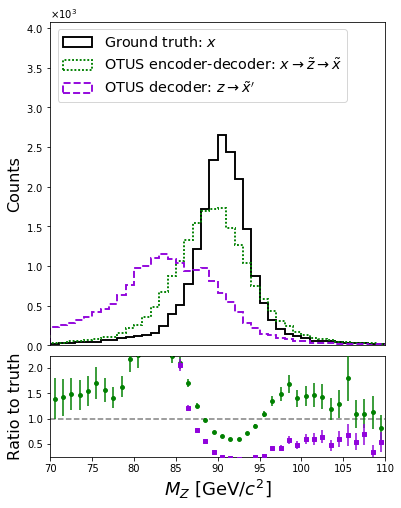

In [23]:
ratioPlotDouble(xval_IM_Z, xpred_IM_Z, xpredtruth_IM_Z, bins, 
                   (70,110), (0,12000), (0.25,2.25),  
                   r'$M_{Z}$ [GeV/$c^2$]', legend=True, save_figs=save_figs, img_dir=img_dir, ablLambda=f'lamb={lamb}') #xIMstatsList[0],  xIMstatsListTruth[0], 

# Create Transport Plots

## Decoder $\tilde{z} \rightarrow \tilde{x}$

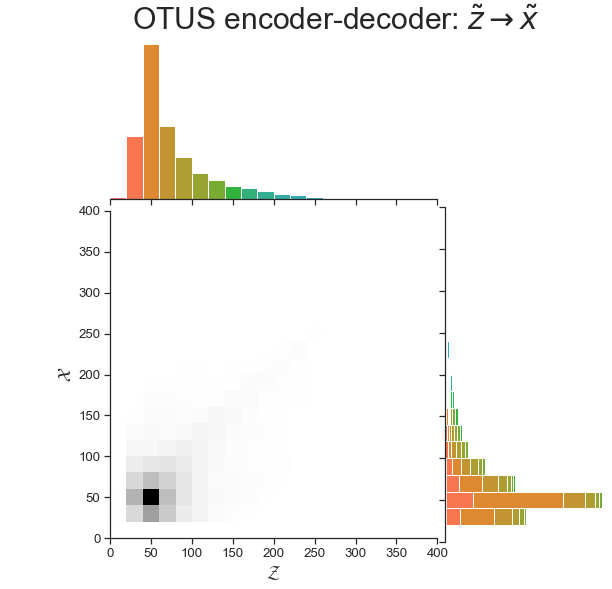

In [24]:
#-- Make decoder transport plot from learned latent space--#

# Positron energy
Z = z_pred_val1[:,7].reshape(-1,1)
X = x_pred_val1[:,7].reshape(-1,1)

n = Z.shape[1]
ZX = [np.concatenate((Z[:,i].reshape(-1,1), X[:,i].reshape(-1,1)), axis=1) for i in range(n)]

transportPlot(ZX[0], zlim=(0,400), xlim=(0,400), nz=20, nx=20, name=f'decTransport_zpred_xpred_val_lamb={lamb}.png', dec=True, title=r'$\hspace{4}$ OTUS encoder-decoder: $\tilde{z} \rightarrow \tilde{x}$', save_figs=save_figs, img_dir=img_dir)